In [1]:
# Citibike 2019 project, analyzing 2018 date of service trip data
# Author: George Chan, Sean Guo

In [32]:
# Import library and modules
import pandas as pd
import glob
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Future use
# https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/

In [3]:
# Define where are the citibke 2018 zipfiles
data_folder = r'/Users/Study/Citibike_Data/'
print('The data are stored in: ' + data_folder)

The data are stored in: /Users/Study/Citibike_Data/


In [4]:
# Check what are the files in that folder
for folderName, subfolders, filenames in os.walk(data_folder):
    print('Here are the list of csv zip files you have downloaded.\n')
    print(folderName)
        
    number_of_csv_file = 0
    all_files = []
    
    # Reference 01: How to get index within for loop?
    # Reference 02: How to pad number with leading zeros?
    for filename in filenames:
        if filename.endswith('.csv'):
            number_of_csv_file += 1
            print('\t' + str(number_of_csv_file).zfill(2) + ': ' + filename)
            all_files.append(data_folder + filename)
            
    # all_files = all_files.sort()
            
    # Warning message if you forgot to download all 12 months.
    # For our project we want exactly 12 file
    if number_of_csv_file != 12:
        print('Sorry, I think you are missing some files?')
        raise SystemExit

Here are the list of csv zip files you have downloaded.

/Users/Study/Citibike_Data/
	01: 201809-citibike-tripdata.csv
	02: 201801-citibike-tripdata.csv
	03: 201803-citibike-tripdata.csv
	04: 201805-citibike-tripdata.csv
	05: 201807-citibike-tripdata.csv
	06: 201811-citibike-tripdata.csv
	07: 201808-citibike-tripdata.csv
	08: 201802-citibike-tripdata.csv
	09: 201812-citibike-tripdata.csv
	10: 201804-citibike-tripdata.csv
	11: 201810-citibike-tripdata.csv
	12: 201806-citibike-tripdata.csv


In [5]:
# Creating a list of all CSV file in the path directory
# all_files = glob.glob(data_folder + "/*.csv")

# tempCitibike list that store the file data frame
tempCitibike = []

# Track how many records total
totalRecordCount = 0

# Loop and append the dataframes into tempCitibke List
for filename in sorted(all_files):
    # Filename is the path/file.ext
    print(os.path.basename(filename), end=" ")
    
    # df contains the entire dataset (CSV)
    df = pd.read_csv(filename) 
    
    # How to filter by values
    # https://stackoverflow.com/q/17071871

    # Experiment to see if only using annual membership will show a different
    # df = df.loc[df['usertype'] == 'Subscriber']
    
    # Radnomly select 10% of the data, with random_state = 1
    df = df.sample(frac = 0.01, replace = True, random_state = 1)
    
    # Output the (rowCount, columnCount) to terminal
    print("size: " + str(df.shape))
    
    totalRecordCount += df.shape[0]
    tempCitibike.append(df)

# Combine the tempCitibike dfs together
citibike = pd.concat(tempCitibike)
print("\nThere are " + "{:,}".format(totalRecordCount) + " number of records.")
print("Before dropping NaN: " + "{:,}".format(citibike.shape[0]))

# Drop rows with any (missing) variables
# Improve performance by not using inplace option
# Reference: https://stackoverflow.com/q/22532302
citibike = citibike.dropna()

print("After dropping NaN:  " + "{:,}".format(citibike.shape[0]))

201801-citibike-tripdata.csv size: (7190, 15)
201802-citibike-tripdata.csv size: (8431, 15)
201803-citibike-tripdata.csv size: (9767, 15)
201804-citibike-tripdata.csv size: (13075, 15)
201805-citibike-tripdata.csv size: (18247, 15)
201806-citibike-tripdata.csv size: (19531, 15)
201807-citibike-tripdata.csv size: (19136, 15)
201808-citibike-tripdata.csv size: (19772, 15)
201809-citibike-tripdata.csv size: (18779, 15)
201810-citibike-tripdata.csv size: (18787, 15)
201811-citibike-tripdata.csv size: (12604, 15)
201812-citibike-tripdata.csv size: (10165, 15)

There are 175,484 number of records.
Before dropping NaN: 175,484
After dropping NaN:  175,452


In [6]:
# Sample my dataset
citibike.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
128037,830,2018-01-28 11:56:43.3930,2018-01-28 12:10:33.6090,326.0,E 11 St & 1 Ave,40.729538,-73.984267,238.0,Bank St & Washington St,40.736197,-74.008592,21256,Subscriber,1958,2
491755,126,2018-01-18 09:31:57.5380,2018-01-18 09:34:04.3190,3113.0,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,3112.0,Milton St & Franklin St,40.729060,-73.957790,33220,Subscriber,1989,1
470924,653,2018-01-05 18:10:32.9340,2018-01-05 18:21:26.2660,3063.0,Nostrand Ave & Myrtle Ave,40.695270,-73.952381,3075.0,Division Ave & Marcy Ave,40.707087,-73.957968,18633,Subscriber,1979,1
491263,821,2018-01-28 16:33:27.7050,2018-01-28 16:47:08.8110,3112.0,Milton St & Franklin St,40.729060,-73.957790,3078.0,Broadway & Roebling St,40.709248,-73.960631,18473,Subscriber,1985,1
371403,559,2018-01-02 19:23:00.5350,2018-01-02 19:32:20.0530,503.0,E 20 St & Park Ave,40.738274,-73.987520,254.0,W 11 St & 6 Ave,40.735324,-73.998004,30669,Subscriber,1952,2


# Question 01: What is monthly total ridership in 2018?

In [17]:
# What is the type of the starttime?
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'numpy.datetime64'>
2018-01-28T11:56:43.393000000


In [18]:
# Need to convert start_time and stop_time to datetime
from datetime import datetime

formatString = '%Y-%m-%d %H:%M:%S.%f'

# Reference 03: Convert datetime column into 
citibike['starttime'] = pd.to_datetime(citibike['starttime'], format=formatString)
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'], format=formatString)

In [19]:
# Confirm such convertion work, should be datetime64!
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'numpy.datetime64'>
2018-01-28T11:56:43.393000000


In [20]:
# Reference 03: Group by month on datetime columns
# Create another pandas dataframe that only has 1 columns
citibike_monthly_df = citibike.filter(['starttime']) # Monthly dataframe
citibike_daily_df = citibike.filter(['starttime'])   # Daily dataframe

# Each of the starttime is now converted into YYYY-MM
citibike_monthly_df.starttime = pd.to_datetime(citibike_monthly_df.starttime).dt.to_period('m')
citibike_daily_df.starttime = pd.to_datetime(citibike_daily_df.starttime).dt.to_period('d')

# Confirm if they are correct
citibike_daily_df.head()
citibike_monthly_df.head()

,starttime
128037,2018-01
491755,2018-01
470924,2018-01
491263,2018-01
371403,2018-01


In [21]:
# Get frequency count of ridership data by month and day
monthly_answer = citibike_monthly_df.groupby(['starttime']).size()
daily_answer = citibike_daily_df.groupby(['starttime']).size()

In [22]:
type(monthly_answer)

pandas.core.series.Series

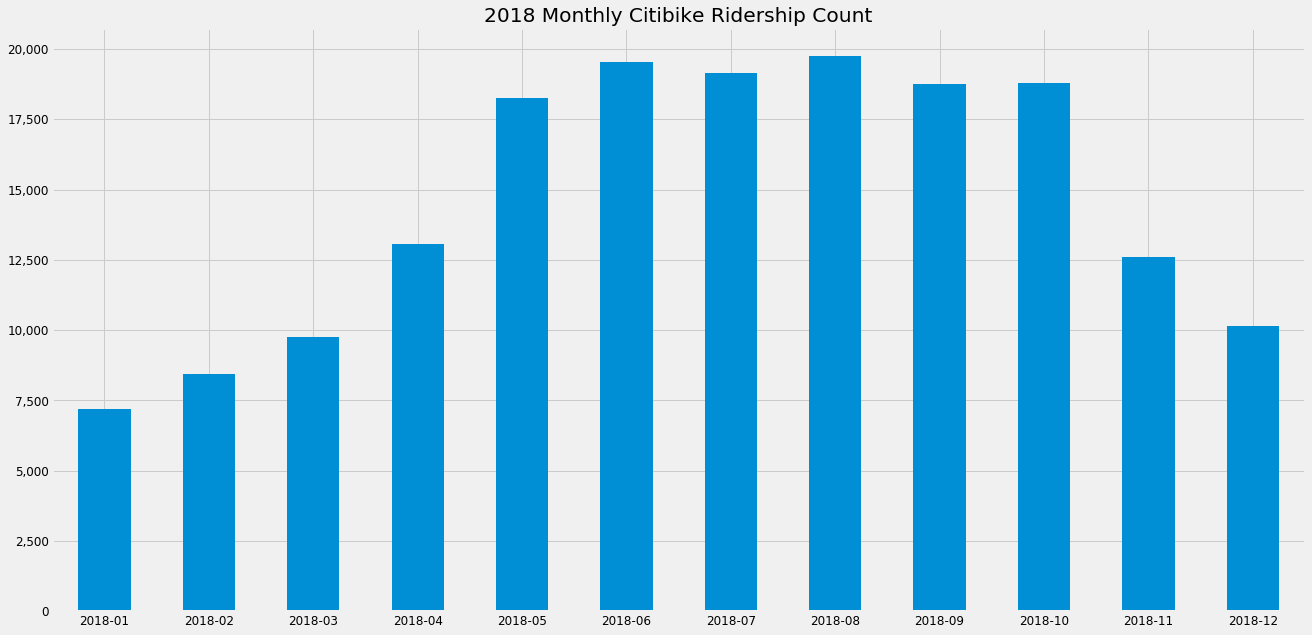

In [33]:
ax = monthly_answer.plot(
    figsize = (20,10), 
    kind = 'bar',
    title = '2018 Monthly Citibike Ridership Count',
    fontsize = 12,
    rot=0)

# Finally learned how to do it, you have to assign it to an object first.
# Reference: https://stackoverflow.com/a/21487560

# Then use set_xlable ...
ax.set_xlabel('')

# Very complicated, 
# Reference: https://stackoverflow.com/a/25973637
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

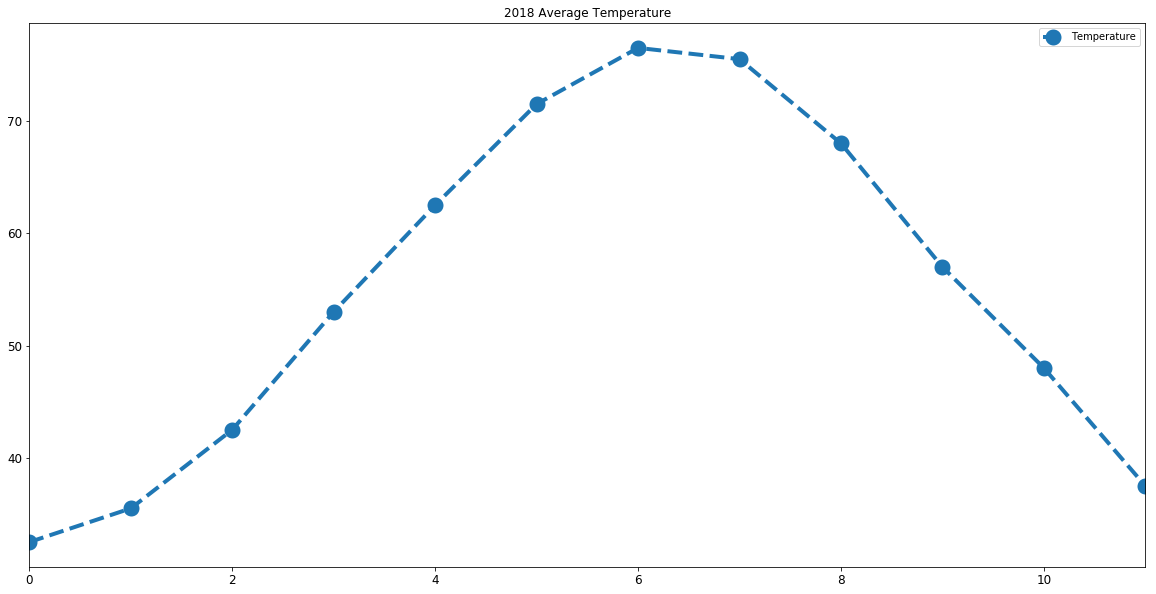

In [24]:
temperature_dict = {
    'Month':['2018-01', 
             '2018-02',
             '2018-03',
             '2018-04',
             '2018-05',
             '2018-06',
             '2018-07',
             '2018-08',
             '2018-09',
             '2018-10',
             '2018-11',
             '2018-12'],
    'Temperature':[32.5, 35.5, 42.5, 53, 62.5, 71.5, 76.5, 75.5, 68, 57, 48, 37.5]
}

temperature_df = pd.DataFrame.from_dict(temperature_dict)

temperature_df.plot(
    figsize = (20,10), 
    kind = 'line',
    title = '2018 Average Temperature',
    fontsize = 12,
    linewidth = 4.0, 
    markeredgewidth = 10.0,
    linestyle = '--', 
    marker = 'o',
    rot = 0)

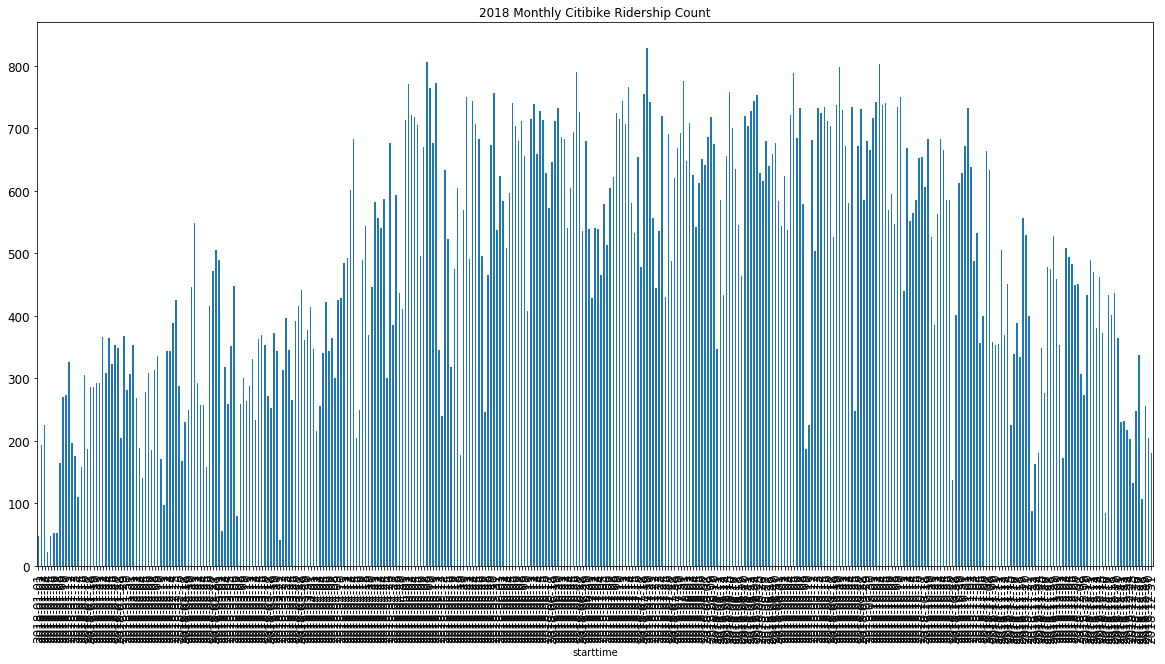

In [25]:
daily_answer.plot(
    figsize = (20,10), 
    kind = 'bar',
    title = '2018 Monthly Citibike Ridership Count',
    fontsize = 12,
    legend=False)

# Question 02: Pending

In [26]:
# Enter Python & Pandas Code here :)

# Question 03: What is the most popular station?

In [27]:
# Most busy start station
# https://stackoverflow.com/q/29836477
# http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
key = 'start station name'
start_station_df = citibike.groupby(key)[key].count().reset_index(name = 'count')
start_station_df.sort_values(by = 'count', ascending = False, inplace = True)

# The most popular start stations award goes to...
print('The most popular start station: ' + str(start_station_df.iloc[0][0]), end = '')
print(' ({:,} times)'.format(start_station_df.iloc[0][1]))

# Most busy end station
key = 'end station name'
end_station_df = citibike.groupby(key)[key].count().reset_index(name = 'count')
end_station_df.sort_values(by = 'count', ascending = False, inplace = True)

print('The most popular end station:   ' + str(end_station_df.iloc[0][0]), end = '')
print(' ({:,} times)'.format(end_station_df.iloc[0][1]))

# Some information about this station
print('\nFrom Wiki: Pershing Square is a public square in Manhattan, New York City. ')
print('Located where Park Avenue and 42nd Street intersect in front of Grand Central Terminal.')
print('The main roadway of Park Avenue crosses over 42nd Street on the Park Avenue Viaduct. ')
print('It is also known as the Pershing Square Viaduct.')

# Top 10 one way direction...
# Chart Annual rider vs. Weekly rider vs. Single rider

# School station analysis (Where do they go?)
# Male and Female trips
# Age Group

# Longest trip (Distance formula)
# Shortest trip (Distance formula)
# Holiday trip (Federal Holiday)

# Number of conected trip ...
# Start and end station by the same user?

# Analysis on commute habbit
# Year of Birth & Gender (Start time and station)
# Morning starting on the train station and ending on the same station

The most popular start station: Pershing Square North (1,511 times)
The most popular end station:   Pershing Square North (1,485 times)

From Wiki: Pershing Square is a public square in Manhattan, New York City. 
Located where Park Avenue and 42nd Street intersect in front of Grand Central Terminal.
The main roadway of Park Avenue crosses over 42nd Street on the Park Avenue Viaduct. 
It is also known as the Pershing Square Viaduct.


In [28]:
# https://stackoverflow.com/q/54009788
# This analysis exclude the trip where they start and end at the same station
# Because it is actually central park, I am guessing for tourist?

# Do not want the trip start and end at the same place
citibike_trip = citibike[citibike['start station name'] != citibike['end station name']]

# Create a subset dataframe with only start & end station name
citibike_trip = citibike_trip.filter(['start station name', 'end station name'])

# Create the trip string
citibike_trip['trip'] = citibike_trip['start station name'] + ' to ' + citibike_trip['end station name']

# Group by trip and add count column
trip_df = citibike_trip.groupby('trip')['trip'].count().reset_index(name = 'count')
trip_df.sort_values(by = 'count', ascending = False, inplace = True)

# Print out the result
print('The most popular ride is : ' + trip_df.iloc[0][0], end = '')
print(' ({} times)'.format(trip_df.iloc[0][1]))
print('The least popular ride is: ' + trip_df.iloc[-1][0], end = '')
print(' ({} times)'.format(trip_df.iloc[-1][1]))

The most popular ride is : E 7 St & Avenue A to Cooper Square & Astor Pl (78 times)
The least popular ride is: old - E 13 St & Avenue A to Washington St & Gansevoort St (1 times)


# Top 10 poupar trips in 2018

In [29]:
# Take a look at the top 10 popular trips
trip_df.head(10)

,trip,count
34280,E 7 St & Avenue A to Cooper Square & Astor Pl,78
17873,Central Park S & 6 Ave to 5 Ave & E 88 St,64
55097,S 4 St & Wythe Ave to N 6 St & Bedford Ave,60
52083,Pershing Square North to Broadway & W 32 St,57
52300,Pershing Square North to W 33 St & 7 Ave,50
53847,Richardson St & N Henry St to Graham Ave & Con...,47
52140,Pershing Square North to E 24 St & Park Ave S,47
52698,Pier 40 - Hudson River Park to West St & Chamb...,46
62923,W 21 St & 6 Ave to 9 Ave & W 22 St,45
2234,12 Ave & W 40 St to West St & Chambers St,45


# What are the type of membership (Annual members or paid per ride?)

In [30]:
membership_df = citibike.groupby('usertype')['usertype'].count()
membership_df = membership_df.reset_index(name = 'count')
membership_df = membership_df.set_index(['usertype'])

# Set the index so it will print properly
membership_df

,count
usertype,
Customer,19293
Subscriber,156159


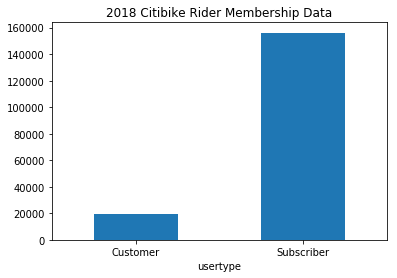

In [31]:
# Reference: https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/
membership_df.plot(
    title = '2018 Citibike Rider Membership Data', 
    kind = 'bar',
    rot = 0,
    legend = None)